In [1]:
import pandas as pd
import time
from finta import TA
import numpy as np
import pandas as pd
import datetime as dt
import copy
import json
from py5paisa import FivePaisaClient

client = FivePaisaClient(email="sudhanshu8833@gmail.com", passwd="Madhya246###", dob="20010626")
client.login()


 20:53:00 | Logged in!!


In [2]:
tickers={"999920005":"BANKNIFTY"}

In [3]:
ohlc_intraday={}
for ticker in tickers:
    print("getting data for: ",tickers[ticker])
    df=client.historical_data('N','C',int(ticker),'5m','2021-05-05','2021-06-05')
    df.set_index("Datetime",inplace=True)
    
    ohlc_intraday[ticker]=df


  

getting data for:  BANKNIFTY


In [4]:
ohlc_intraday

{'999920005':                          Open      High       Low     Close  Volume
 Datetime                                                           
 2021-05-05T09:15:00  32577.10  32602.30  32440.00  32533.30       0
 2021-05-05T09:20:00  32539.05  32554.90  32402.85  32427.80       0
 2021-05-05T09:25:00  32427.85  32495.55  32418.40  32463.90       0
 2021-05-05T09:30:00  32466.35  32542.55  32462.05  32481.70       0
 2021-05-05T09:35:00  32486.75  32560.90  32482.70  32484.05       0
 ...                       ...       ...       ...       ...     ...
 2021-06-04T15:10:00  35265.30  35297.45  35263.75  35285.40       0
 2021-06-04T15:15:00  35288.40  35314.00  35277.70  35285.15       0
 2021-06-04T15:20:00  35279.90  35333.10  35279.90  35325.95       0
 2021-06-04T15:25:00  35325.50  35347.85  35325.50  35343.50       0
 2021-06-04T15:30:00  35343.50  35343.50  35343.50  35343.50       0
 
 [1672 rows x 5 columns]}

In [5]:
ohlc_dict=copy.deepcopy(ohlc_intraday)

In [6]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    df.drop(["MA_Fast","MA_Slow"],axis=1)
    return df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*74)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*74)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

def win_pct(DF):
    df=DF.copy()
    j=0
    for i in range(len(df)):
        if df["profit"][i]>0:
            j+=1

    win_percent=j/len(df)*100

    return win_percent
            


In [7]:
tickers_signal = {}
ticker_ret = {}

In [8]:
for ticker in tickers:

    ohlc_dict[ticker].columns=["open","high","low","close","volume"]
    ohlc_dict[ticker]["fisher 20"]=TA.FISH(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["fisher 10"]=TA.FISH(ohlc_dict[ticker],10)    
    ohlc_dict[ticker]["RSI 16"]=TA.RSI(ohlc_dict[ticker],16)
    ohlc_dict[ticker]["RSI 21"]=TA.RSI(ohlc_dict[ticker],21)
    ohlc_dict[ticker]["MACD macd line"]=MACD(ohlc_dict[ticker],12,26,9)["MACD"]
    ohlc_dict[ticker]["MACD signal line"]=MACD(ohlc_dict[ticker],12,26,9)["Signal"]
    
    ohlc_dict[ticker].dropna(inplace=True)
    

In [9]:
ticker_signal={}
ticker_ret={}
ohlc_database={}
price_in=[]
price_out=[]
order=[]
stock=[]


In [10]:
for ticker in tickers:
    ticker_signal[ticker]=[]
    ticker_ret[ticker]=[]
    ohlc_database[ticker]=pd.DataFrame()

    ohlc_dict[ticker].rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"},inplace=True)
    
for ticker in tickers:
    signal=""
    for i in range(len(ohlc_dict[ticker])):
        if signal=="":
            if ohlc_dict[ticker]["fisher 10"][i]>0 and ohlc_dict[ticker]["fisher 10"][i-1]<0 and ohlc_dict[ticker]["RSI 16"][i]>50: 
                signal="buy"
                price=ohlc_dict[ticker]["Close"][i]
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("long")
                stock.append(ticker)

                
               



            elif (ohlc_dict[ticker]["fisher 20"][i]<0 and ohlc_dict[ticker]["fisher 20"][i-1]>0) and ohlc_dict[ticker]["MACD macd line"][i]<ohlc_dict[ticker]["MACD signal line"][i] and ohlc_dict[ticker]["RSI 21"][i]<42.5:
                signal="sell"
                price=ohlc_dict[ticker]["Close"][i]
                
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("short")
                stock.append(ticker)                
            ticker_ret[ticker].append(0)

        elif signal=="buy":
            if (ohlc_dict[ticker]["fisher 20"][i]<0.5 and ohlc_dict[ticker]["fisher 20"][i-1]>0.5) or ohlc_dict[ticker]["Close"][i]>=price+.02*price or ohlc_dict[ticker]["Close"][i]<=price-.008*price:

                signal=""
                price_out.append(ohlc_dict[ticker]["Close"][i])
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)

            
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
           
        
        
        elif signal=="sell":
            if (ohlc_dict[ticker]["fisher 20"][i]>-1 and ohlc_dict[ticker]["fisher 20"][i-1]<-1) or (ohlc_dict[ticker]["fisher 20"][i]>0 and ohlc_dict[ticker]["fisher 20"][i-1]<0) or ohlc_dict[ticker]["Close"][i]<=price +.02*price or ohlc_dict[ticker]["Close"][i]>=price-.005*price:
                price_out.append(ohlc_dict[ticker]["Close"][i])

                signal=""
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)

          
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
    if len(price_in)!=len(price_out):
        price_out.append(ohlc_dict[ticker]["Close"][-1])
    ohlc_dict[ticker]["ret"] = np.array(ticker_ret[ticker])    

In [11]:
ohlcv_database=pd.DataFrame()

ohlcv_database["price_in"]=np.array(price_in)
ohlcv_database["price_out"]=np.array(price_out)
ohlcv_database["order"]=np.array(order)
ohlcv_database["stock"]=np.array(stock)

In [12]:
profit=[]
for i in range(len(ohlcv_database)):
    if ohlcv_database["order"][i]=="long":
        profit.append(((ohlcv_database["price_out"][i]-ohlcv_database["price_in"][i])/ohlcv_database["price_in"][i])*100)

    elif ohlcv_database["order"][i]=="short":
        profit.append(((ohlcv_database["price_in"][i]-ohlcv_database["price_out"][i])/ohlcv_database["price_out"][i])*100)

ohlcv_database["profit"]=np.array(profit)

In [13]:
ohlcv_database

,price_in,price_out,order,stock,profit
0,32739.65,32586.50,long,999920005,-0.467781
1,32723.05,32737.65,long,999920005,0.044617
2,32714.55,32786.10,long,999920005,0.218710
3,32886.50,32978.45,long,999920005,0.279598
4,33030.15,32887.20,long,999920005,-0.432786
5,33181.55,33204.85,long,999920005,0.070220
6,33243.40,33125.50,long,999920005,-0.354657
7,33191.50,32721.05,long,999920005,-1.417381
8,32766.70,32778.65,short,999920005,-0.036457
9,32662.25,32679.85,short,999920005,-0.053856


In [14]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)



0.7475143477864385

<AxesSubplot:xlabel='Datetime'>

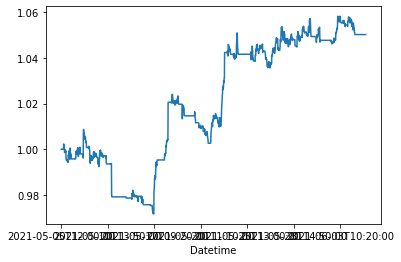

In [15]:
(1+strategy_df["ret"]).cumprod().plot()

In [16]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
win_pcts={}
for ticker in tickers:
    win=[]
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    for i in range(len(ohlcv_database)):
        if ohlcv_database["stock"][i]==ticker:
            
            win.append(ohlcv_database["profit"][i])
    win_df=pd.DataFrame()
    win_df["profit"]=np.array(win)
    win_pcts[ticker]=win_pct(win_df)           

    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown,win_pcts],index=["Return","Sharpe Ratio","Max Drawdown","win_pct"])      
KPI_df.T


calculating KPIs for  999920005


,Return,Sharpe Ratio,Max Drawdown,win_pct
999920005,0.747514,4.928873,0.036714,38.636364
